In [96]:
import json
import random
import pandas as pd
import sqlite3

"""
feature_table(ft):
    index, feature, image, label をカラムとしてDataFrame形式で格納したデータ.

feature_table_indexes(ftis): 
    feature_tableのindexをjson形式で格納したデータ. フィーチャの状態(train, trained, query, selected_query)を記録.
    train -> 次の学習で訓練するフィーチャのindex
    trained ->  1度以上学習済みのフィーチャのindex
    query -> 次の学習データを選択するために利用する近傍探索のクエリフィーチャのindex
    selected_query -> 1度以上選択されたクエリフィーチャのindex
"""

# feature_table(ft) をDataFrame形式で読み込み
def load_feature_table(dbpath, tablename="feature_table"):
    conn=sqlite3.connect(dbpath)
    c = conn.cursor()
    ft = pd.read_sql('SELECT * FROM ' + tablename, conn)
    return ft

# feature_table_indexes(ftis) をランダムに初期化
def init_feature_table_indexes(feature_table, seed=1):
    random.seed(seed)
    ft = feature_table
    ftis = {} # feature_table_indexes
    ftis["train"],ftis["trained"], ftis["query"], ftis["selected_query"] = [], [], [], []
    labels = sorted(ft["label"].unique())
    ft_labelby = ft.groupby("label")
    for label in labels:
        df = ft_labelby.get_group(label)
        queries = df["index"].values.tolist()
        query = random.sample(queries, 1)[0]
        ftis["query"].append(query)
    return ftis

# feature_table_indexes(ftis) をjson形式で保存
def save_feature_table_indexes(ftis, savepath):
    with open(savepath, "w") as f:
        json.dump(ftis, f, indent=4)
        
# feature_table_indexes(ftis) を辞書形式で読み込み
def load_feature_table_indexes(ftis_path):
    with open(ftis_path, "r") as f:
        ftis = json.load(f)
    return ftis

In [235]:
import json
import sys
import faiss
import numpy as np

# 次に学習するフィーチャを持つデータを選択
class TrainFeatureSelector:
    
    def __init__(self, feature_table, feature_table_indexes):
        self.ft = self.__drop_trained_data(feature_table, feature_table_indexes)
        self.ftis = feature_table_indexes
        self.labels = sorted(feature_table["label"].unique())
        self.faiss_indexes = {} # ラベルごとのフィーチャ全体のfaissインデックス
              
    def __drop_trained_data(self, feature_table, feature_table_indexes):
        ft = feature_table.drop(index=feature_table_indexes["trained"])
        ft = ft.reset_index(drop=True)
        return ft
    
    def out_feature_table_indexes(self):
        return self.ftis
    
    # フィーチャを検索するための,フィーチャ全体のfaissインデックスを作成
    def make_faiss_indexes(self):
        ft_labelby = self.ft.groupby("label")
        for label in self.labels:
            features = []
            df = ft_labelby.get_group(label)
            for feature in df["feature"]:
                features.append(json.loads(feature))
            features = np.array(features).astype("float32")
            dim = len(features[0])
            index = faiss.IndexFlatL2(dim)
            index.add(features)
            self.faiss_indexes[label] = index
    
    # ラベルごとにクエリと最近傍(NN)のフィーチャをdataN分選択し、選択したフィーチャのftisをftis["train"]に追加
    def select_NN_train(self, dataN):
        if len(self.faiss_indexes) is 0:
            print("\nPlease run the process to make faiss indexes in advance.")
            sys.exit()
        ft_labelby = self.ft.groupby("label")
        for label in self.labels:
            index = self.faiss_indexes[label]
            k = index.ntotal # 検索対象データ数
            query = self.ft[self.ft["index"]==self.ftis["query"][label]]["feature"].iat[0]
            query = json.loads(query)
            query = np.array([query]).astype("float32")
            D, I = index.search(query, k)
            self.ftis["selected_query"].append(self.ftis["query"][label])
            for i in I[0][:dataN + 1]:
                train_index = ft_labelby.get_group(label).iloc[i]["index"]
                if train_index == self.ftis["query"][label]: continue # クエリはtrainに含めない
                self.ftis["train"].append(train_index)
    
    # クエリを最遠傍点(FP)に更新
    def update_FP_queries(self):
        if len(self.faiss_indexes) is 0:
            print("\nPlease run the process to make faiss indexes in advance.")
            sys.exit()
        ft_labelby = self.ft.groupby("label")
        for label in self.labels:
            index = self.faiss_indexes[label]
            k = index.ntotal # 検索対象データ数
            query = self.ft[self.ft["index"]==self.ftis["query"][label]]["feature"].iat[0]
            query = json.loads(query)
            query = np.array([query]).astype("float32")
            D, I = index.search(query, k)
            for i in reversed(I[0]):
                FP_query_index = ft_labelby.get_group(label).iloc[i]["index"]
                if FP_query_index not in self.ftis["selected_query"]:
                    break
            self.ftis["query"][label] = FP_query_index
            """
            for i in range(1, k):
                FP_query_index = ft_labelby.get_group(label).iloc[I[0][-i]]["index"]
                if FP_query_index not in self.ftis["selected_query"]:
                    break
            print(FP_query_index)
            self.ftis["query"][label] = FP_query_index
            """

In [158]:
# TrainFeatureSelector　の検証用
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

# torch画像配列の可視化
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# feature_tableのindexで指定した画像を可視化
def imshow_ftis(feature_table, feature_table_index):
    image = json.loads(feature_table[feature_table["index"]==feature_table_index]["image"].iloc[0])
    image = np.array(image)
    image = torch.from_numpy(image.astype(np.float32)).clone()
    imshow(image)

In [208]:
dbpath = "./assets/features_v1.db"
feature_table = load_feature_table(dbpath)

In [220]:
# selector のselect_NN_trainのtest
feature_table_indexes = init_feature_table_indexes(feature_table, seed=5)
print("before ftis:\n{0}".format(feature_table_indexes))
selector = TrainFeatureSelector(feature_table, feature_table_indexes)
selector.make_faiss_indexes()
selector.select_NN_train(dataN=10)
ftis = selector.out_feature_table_indexes()
print("after ftis:\n{0}".format(ftis))

before ftis:
{'train': [], 'trained': [], 'query': [6192, 8797, 13085], 'selected_query': []}
after ftis:
{'train': [2520, 8298, 7113, 14714, 9691, 5374, 10248, 11400, 8534, 8738, 2388, 13282, 8255, 13852, 7533, 9624, 13764, 365, 2862, 6923, 3270, 9890, 8793, 14995, 3441, 703, 7990, 526, 1267, 1648], 'trained': [], 'query': [6192, 8797, 13085], 'selected_query': [6192, 8797, 13085]}


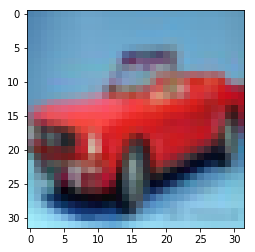

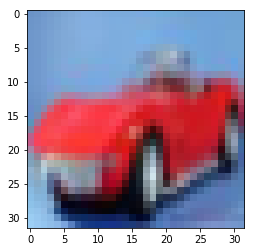

In [216]:
imshow_ftis(feature_table, 6192) # クエリの画像
imshow_ftis(feature_table, 2520) # クエリと最近傍の画像

In [236]:
# selector のupdate_FP_queriesのtest
feature_table_indexes = init_feature_table_indexes(feature_table, seed=5)
print("before ftis:\n{0}".format(feature_table_indexes))
selector = TrainFeatureSelector(feature_table, feature_table_indexes)
selector.make_faiss_indexes()
selector.update_FP_queries()
selector.select_NN_train(dataN=10)
ftis = selector.out_feature_table_indexes()
print("after ftis:\n{0}".format(ftis))

before ftis:
{'train': [], 'trained': [], 'query': [6192, 8797, 13085], 'selected_query': []}
after ftis:
{'train': [4881, 13227, 9415, 6348, 12143, 242, 2200, 10115, 1426, 7431, 3955, 5455, 7906, 4882, 9697, 6607, 8779, 10775, 7420, 5133, 1246, 9870, 7604, 9606, 11608, 9933, 3821, 5793, 8, 10624], 'trained': [], 'query': [14993, 5820, 4840], 'selected_query': [14993, 5820, 4840]}


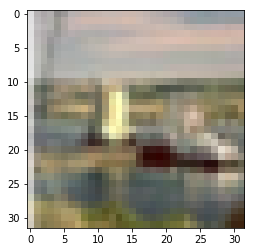

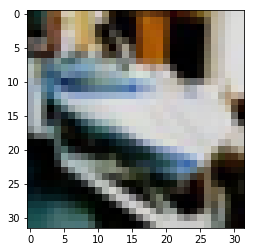

In [238]:
imshow_ftis(feature_table, 13085) # クエリの画像
imshow_ftis(feature_table, 10624) # クエリと最遠傍の画像

In [232]:
a = [1,2,3,4,5]
a[::-1]

[5, 4, 3, 2, 1]

In [234]:
for i in reversed(a):
    print(i)

5
4
3
2
1
